# INF221 Assignment 1
Jon Nordby, September 2017

In [5]:
#%load_ext line_profiler

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

import math
import random
import time

import numpy
import pandas

# Exercise 1

Other than speed, what other measures of efficiency might one use in a real-world setting?

Here are some considerations other than execution speed of an algorithm:

#### Memory efficiency

A more memory efficient program may solve a bigger problem with a given amount of memory.
Even when there is sufficient memory, a more memory efficient algorithm may more often fit into the much faster memory caches of the processor.

#### Parallelizability

A single processor may not have the memory or processing power to perform a task in the desired amount of time. For big problem sizes, the ability to make efficient use of multiple processors (CPU, GPU) and multiple machines is critical.

#### Throughput versus latency

In some applications high throughput is desirable: perform as many tasks as possible per unit of time.
In other applications, low latency is desirable: complete each task in the lowest amount of time.

#### Bounded latency

In a realtime applications, tasks either *should* (soft-realtime) or *must* be completed within a give timeframe.

For soft-realtime application, like drawing the next frame of a computer game, efficiency can be how often (statistically) the program can maintain its deadline.

For hard-realtime, like a robot that acts on moving objects, the worst-case performance must always within the deadline.

#### Resumability and cancelability

In interactive application it may be desirable to show partial or in-progress results of a long-running computation. Where the inputs of such computations can be change rapidly, it is desirable to be able to cancel existing computations without running them to completion.

#### Energy usage

Many computing devices are energy constrained, either because they run on battery or have limited thermal budget.
How a program is written can have big impacts on how energy efficient the device is. 


# Exercise 2
For inputs of size `n`, insertion sort runs in `8n^2` steps, while merge sort runs in `64 n log(n)`.

For which values of `n` does insertion sort beat merge sort?

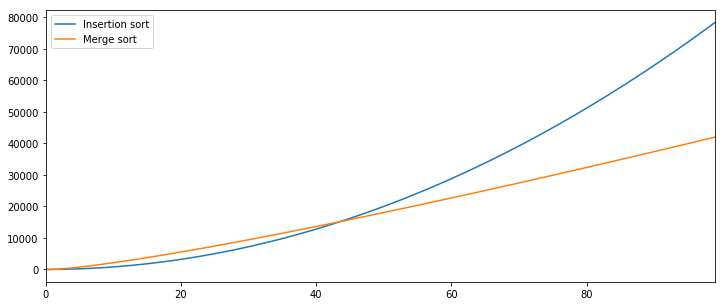

In [71]:
def insertion_sort_complexity(n):
    return 8*(n**2)
def merge_sort_complexity(n):
    if n == 0:
        return 0
    return 64*n*math.log(n, 2)

N = 100
series = {
    'Insertion sort': list(insertion_sort_complexity(n) for n in range(N)),
    'Merge sort': list(merge_sort_complexity(n) for n in range(N)),
}
f = pandas.DataFrame(data=series, index=range(N))
f.plot()

Theoretically merge sort should be faster than insertion sort for N < 42

## Experimental results in Python

### Merge sort

In [65]:
# The most simplest fast-ish implementation of mergesort I could find
# From http://interactivepython.org/courselib/static/pythonds/SortSearch/TheMergeSort.html
# As authors note, the slicing operations ( alist[:mid] ) is O(k) runtime complexity with size of slice
# However for small values of k compared here, it is not a significant bottleneck (checked with profiler)
def merge_sort(alist):
    if len(alist) > 1:
        mid = len(alist)//2
        lefthalf = alist[:mid]
        righthalf = alist[mid:]

        merge_sort(lefthalf)
        merge_sort(righthalf)

        i=0
        j=0
        k=0
        left_len = len(lefthalf)
        right_len = len(righthalf)
        while i < left_len and j < right_len:
            if lefthalf[i] < righthalf[j]:
                alist[k]=lefthalf[i]
                i=i+1
            else:
                alist[k]=righthalf[j]
                j=j+1
            k=k+1

        while i < left_len:
            alist[k]=lefthalf[i]
            i=i+1
            k=k+1

        while j < right_len:
            alist[k]=righthalf[j]
            j=j+1
            k=k+1

    return alist

def test_merge(N, runs, check_correctness=True):
    for r in range(runs):
        i = list(random.randint(-N, N) for n in range(N))
        s = merge_sort(i)
        if check_correctness:
            r = sorted(i)
            assert s == r, "%s: %s != %s" % (i, s, r)

#%timeit test_merge(50, 100)
%lprun -f merge_sort test_merge(5000, 10)

### Insertion sort

In [49]:
def insertion_sort(s):
    for i in range(1, len(s)):
        val = s[i]
        j = i - 1
        while j >= 0 and s[j] > val:
            s[j+1] = s[j]
            j = j - 1
        s[j+1] = val
    return s

def test_insertion(N, runs, check_correctness=True):
    for r in range(runs):
        i = list(random.randint(-N, N) for n in range(N))
        s = insertion_sort(i)
        if check_correctness:
            r = sorted(i)
            assert s == r

%timeit test_insertion(50, 100)

10 loops, best of 3: 67 ms per loop


Testing shows a cross-over point in runtime for these implementations slightly higher than the theoretical value, around 50 instead of 42.

It could be that our constants (8, 64) would need to be tweaked to fit our real-life implementations. Some of this could be due to the constant-time initialization of test data which is also part of the measurement.

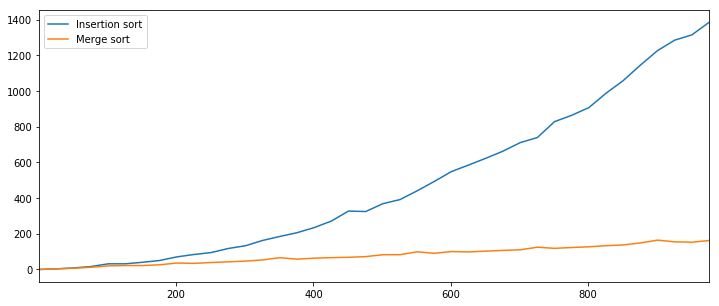

In [80]:
insert_times = []
merge_times = []
ns = range(1, 1000, 25)
for n in ns:
    runs = 10
    
    before_insert = time.perf_counter()
    test_insertion(n, runs, check_correctness=False)
    after_insert = time.perf_counter()
    
    before_merge = time.perf_counter()
    test_merge(n, runs, check_correctness=False)
    after_merge = time.perf_counter()
    
    insert_times.append((after_insert - before_insert)*1000)
    merge_times.append((after_merge - before_merge)*1000)
    
actual = {
    'Insertion sort': insert_times,
    'Merge sort': merge_times,
}
f = pandas.DataFrame(data=actual, index=ns)
f.plot()

Experimental results for slightly larger N confirms that merge sort beats the insertion. At N=1000, a very small list by computer standards, the difference is already more than one order of magnitude.

# Exercise 3
What is the smallest value of `n` such that an algorithm whose running time is `100*n^2` is faster than an algorithm whose running time is `2^n` on the same machine?

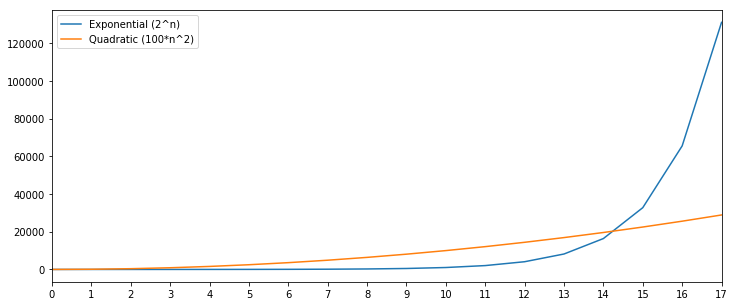

In [83]:
def quadratic(n):
    return 100*n**2
def exponential(n):
    return math.pow(2, n)

N = 18
series = {
    'Quadratic (100*n^2)': list(quadratic(n) for n in range(N)),
    'Exponential (2^n)': list(exponential(n) for n in range(N)),
}
df = pandas.DataFrame(data=series)
df.plot(xticks=range(N))

It appears that N=15 is the smallest value where a computation with runtime `100*n^2` is faster than one with runtime `2^n`.

# Exercise 4

Consider the searching problem:

**Input**: A sequence of `n` numbers: `A = a_1, a_2, …, a_n` and a value `v`

**Output**: An index `i` such that `v = A[i]`, or the special value `NIL` if `v` does not appear in `A`.

Write pseudocode for linear search, which scans through the sequence, looking for `v`. Using a loop invariant, prove that the algorithm is correct. Make sure your loop invariant fulfills the three necessary properties.

In [17]:
# Using Python is executable pseudo-code :)
def find_value(A, v):
    found = None
    i = 0
    L = len(A)
    while i < L and found is None:
        if A[i] == v:
            found = i
        else:
            i += 1

    return found

This is a mostly standard implementation of a linear search using a while statement.
However, instead of returning i directly when found (`if A[i] == v: return i`)
we have lifted the termination check into the loop guard (`found is None`)
to only have a single exit from the function.

#### Choosing the loop invariant

For the loop invariant to be useful, it should be chosen such that when the loop terminates *(I & !G)*, then our desired post-condition *P* must hold. `I & !G ==> P`

* (G)uard: `i < L and found is None`
* (P)ost-condition: `v = A[i] or NIL if v not in A`
* Loop (I)nvariant: `v not in A[0:i]`, where 0:i is up-until, but-not-including i

Analysing the implementation on the normal case of a *non-zero length* array.

#### Initialization

Before entering the loop we have `i=0`. The set `A[0:i]` is `A[0:0]` i.e the empty set and cannot contain `v`. The invariant holds.

#### Maintenance

After an iteration of the loop, the value may have been found or not.

If the value was found, `A[0:i]` is `A[0:0]` which cannot contain `v`. The loop invariant holds.

If the value was not found, then i is incremented by 1. `A[0:i]` is `A[0:1]`, is `A[0]`, which did not contain the value. The loop invariant holds.


#### Termination

The loop will terminate when `i < L` becomes `False`, or if `found is None` becomes `False`. `L` is a constant number, never modified in the loop. If the value is found, then found is set to a number `i` which is not None and it terminates. Otherwise `i` is incremented by 1, which progresses towards falsifying `i<L` and will terminate.

# Appendix A: Property-based testing

Property-based testing allows automatically generating a range of testcases. It requires specifying a generator of valid inputs, and a function which can check the invariants of the code under test for any such input.

Libraries exist that can aid in this style of testing, including [Hypothesis](https://hypothesis.readthedocs.io/en/latest/). Many include automatic testcase reduction for disproved cases, stemming from the original Quickcheck. Here we do it the manual way, without any special libraries.

These tests were used to verify correctness when playing with different search implementations

In [6]:
# Create randomized but valid test input. 
def generate_input():
    N = random.randint(0, 100)
    def rand():
        return random.randint(-N, N)

    v = rand()
    # Make it semi-likely that v exists in L
    L = list(rand() for n in range(N*2))
    return (L, v)

# Helper: Get L[idx], without exploding when idx does not exist in L
def list_get(L, idx, default=None):
    try:
        return L[idx]
    except IndexError:
        return default

# Built-in index() function of Python lists is our definition of truth, an oracle
def oracle_find(A, v):
    try:
        return A.index(v)
    except ValueError:
        return None # not found
    
# Check that the @index found is correct
# If not, raises AssertionError
def verify_result(L, v, index):
    # Obeys postcondition?
    if index is not None:
        # Invariant: A[i] = v
        assert L[index] == v, "Search returned i=%d, but A[i] != v: %d != %d" % (index, list_get(L, index), v) 
    else:
        # Invariant: NIL -> v does not exist in L
        assert v not in L, "Search did not find v, but v=%d exists in L at %d" % (v, L.index(v))

    # Oracle agrees?
    i_oracle = oracle_find(L, v)
    assert i_oracle == index, "Orace says %d, search returned %d" % (i_oracle, index)

def property_test(testee):
    A, v = generate_input()
    i_ours = testee(A, v)
    verify_result(A, v, i_ours)
    return "not in A" if i_ours is None else "%d %d == %d: %s" % (len(A), A[i_ours], v, str(A[i_ours] == v))

# Run a range of tests against @func
def test_search(func):
    return list(property_test(func) for i in range(0, 50))

# like unittest.TestCase.assertRaises(), just as a free-standing function
def assert_raises(func, expected, *args, **kwargs):
    try:
        func(*args, **kwargs) 
    except Exception as e:
        message = str(e)
        assert expected in message, "Exception message '%s' did not match expected '%s'" % (message, expected) 
    else:
        raise AssertionError("Function did not raise any Exception")

Check that our tests fails buggy implementations:

In [7]:
# Some incorrect search functions
def find_value_fail_nofound(A, v):
    for i in range(0, len(A)):
        if A[i] == v:
            return i
    return -1 # BUG: incorrect sentinel value

def find_value_inverted(A, v):
    for i, a in enumerate(A):
        if a != v: # BUG: inverted condition
            return i
    return None

def find_value_noiter(A, v):
    for i in range(len(A), 0): # BUG: range parameters flipped
        if A[i] == v:
            return i
    return None

assert_raises(lambda : test_search(find_value_inverted), "A[i] != v")
assert_raises(lambda : test_search(find_value_fail_nofound), "A[i] != v")
assert_raises(lambda : test_search(find_value_noiter), "did not find v")

'tests catches the bugs'

'tests catches the bugs'

Testing that correct implementations pass:

In [18]:
def find_value_for_range(A, v):
    for i in range(0, len(A)):
        if A[i] == v:
            return i
    return None

def find_value_while(A, v):
    i = 0
    L = len(A)
    while i < L:
        if A[i] == v:
            # because return breaks out of loop, i is not incremented
            # Unclear how this reacts with loop invariant
            return i
        i += 1

    return None

test_search(find_value)
test_search(find_value_while)
test_search(find_value_for_range)

'all tests passed'

'all tests passed'

# Appendix B: Design-by-contracts

Languages like Eiffel have integrated support for checking loop invariants, as well as function pre- and post-conditions. This automatically inserts checks at runtime from the specifications used by proofs.
We can get something similar in Python if we use our own `while` function.

In [23]:
# A while loop that ensures 
def while_loop(vars, guard, body, loop_invariants):
    loop_invariants(**vars) # initial
    while guard(**vars):
        loop_invariants(**vars) # each time
        body(vars, **vars)

def check_loop_invariants(A, v, i, **_):
    visited = A[0:max(i, 0)]
    assert v not in visited, "Value v=%d exists in parts of A already visited at %d. i=%d " % (v, visited.index(v), i)

def check_postconditions(A, v, found, **_):
    if found is None:
        assert v not in A
    else:
        assert A[found] == v

def check_preconditions(A, v, **_):
    def is_integer(obj):
        integers = (int,)
        return isinstance(v, integers)
    assert is_integer(v)
    assert all(map(is_integer, A))

# A very non-Pythonic implementation of find_value_single_exit()
def guard(A, v, i, found):
    return i < len(A) and found is None

def body(out, A, i, v, **_):
    if A[i] == v:
        out['found'] = i
    else:
        out['i'] += 1

def find_value_functional(A, v):
    check_preconditions(A, v)
    vars = {
        'A': A,
        'v': v,
        'i': 0,
        'found': None
    }
    while_loop(vars, guard, body, check_loop_invariants)
    
    check_postconditions(**vars)
    return vars['found']

test_search(find_value_functional);

If we inject a fault in the function instrumented to check loop-invariant at runtime, then it catches the bug before we even returns a result for the tests to check. Integrating checking into the code itself is a defensive programming strategy.

In [24]:
# Inject fault into find_value_functional
working = body
def broken(out, A, i, v, **_):
    #out['found'] = i if A[i] == v else None
    out['i'] += 1
body = broken

# Check that our loop invariant check catches it
assert_raises(lambda : test_search(find_value_functional), "exists in parts of A already visited")
body = working

'bug caught by loop invariant'

'bug caught by loop invariant'